In [10]:
#importing modules
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [11]:
#giving path of each tumor
path_meningioma_tumor = 'brain_tumor_dataset/1'
path_glioma_tumor = 'brain_tumor_dataset/2'
path_pituitary_tumor = 'brain_tumor_dataset/3'

In [12]:
# giving labels to tumor
label_map = {
    path_meningioma_tumor: 0,
    path_glioma_tumor: 1,
    path_pituitary_tumor: 2
}

In [13]:
# loading the images from paths
x = []
y = []

for path, label in label_map.items():
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if os.path.isfile(file_path):
            image = cv2.imread(file_path)
            if image is not None:
                image = cv2.resize(image, (200, 200)) #resizing the images
                resized_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                x.append(resized_image_rgb)
                y.append(label)

x = np.array(x)
y = np.array(y)

In [14]:
x #here 68 represents the intensity of the red channel,1-blue channel,84-green channel dark blue color is mainly stored

array([[[[68,  1, 84],
         [68,  1, 84],
         [68,  1, 84],
         ...,
         [68,  1, 84],
         [68,  1, 84],
         [68,  1, 84]],

        [[68,  1, 84],
         [68,  1, 84],
         [68,  1, 84],
         ...,
         [68,  1, 84],
         [68,  1, 84],
         [68,  1, 84]],

        [[68,  1, 84],
         [68,  1, 84],
         [68,  1, 84],
         ...,
         [68,  2, 85],
         [68,  1, 84],
         [68,  1, 84]],

        ...,

        [[68,  1, 84],
         [68,  1, 84],
         [68,  1, 84],
         ...,
         [68,  2, 85],
         [68,  1, 84],
         [68,  1, 84]],

        [[68,  1, 84],
         [68,  1, 84],
         [68,  1, 84],
         ...,
         [68,  1, 84],
         [68,  1, 84],
         [68,  1, 84]],

        [[68,  1, 84],
         [68,  1, 84],
         [68,  1, 84],
         ...,
         [68,  1, 84],
         [68,  1, 84],
         [68,  1, 84]]],


       [[[68,  1, 84],
         [68,  1, 84],
         [68, 

In [15]:
y ##indicates the labels

array([0, 0, 0, ..., 2, 2, 2])

In [16]:
#count of each tumor
print(pd.Series(y).value_counts())

1    1426
2     930
0     708
Name: count, dtype: int64


If the random_state in not there, then every time you run(execute) your code a new random value is generated and the train and test datasets would have different values each time.

In [17]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10, test_size=0.3)

Since we are working with neural networks,the neural network will perform well when input values are in range of [0,1] or [-1,1]
So,to achieve this we do normalization of the values.original range[0,255]
astype('float32') converts the data type of the pixel values from integers (it is generally unit8(8-bit integers)) to 32-bit floating point numbers

In [18]:
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Here the input layer will take 200 X200 image with 3 color channels(RGB) then convolutional layer is built with 32 filters(each filters will learn to detect various features like shape,size,texture and output 32 diff 2 dimensional one for each filter) with size 3X3 which uses activation fuction(introduce non-linearity to model to learn complex structures) ReLU(rectified linear unit) which make sures that input recieved by conv1 is not negative value since it will cause slower processing and less optimized.Next pooling layer1 is built which reduces the dimension by factor of 2 and by including MaxPooling2D layers,the important features are preserved while the less important details are removed, leading to a more efficient and effective neural network.(2,2)represents the pooling window size.MaxPooling2D operates by sliding a window (of specified size) over the input and taking the maximum value within the window for each position. The size of the window determine how much the input is downsampled.next in flatten layer the 3D ouput from previous layer is converted to 1D vector because we have to send to fully connected layers.Dense1(fully connected input layer used for connecting input to corresponding outputs) will flatten the outputs from previous layers and output_layer(first fully connected output layer) will gives the final probabilities for each label.next cnn_model will combine the layers into a Keras model with specified input and output layers.

Then the model is compiled which used the optimizer whose function is to determine how weights are adjusted based on gradient loss function.'adam'(adaptive movement estimation full form)is  used because of its efficiency and ability to adapt learning rates(dynamically adjusts) for each parameter.loss function(sparse:Assumes the target labels are integers)computes the difference between the predicted and true labels during training.metrics evaluates the model's performance based on accuracy during training and validation.

In [19]:
#build model
input_layer = Input(shape=(200, 200, 3))
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu')(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)
flatten = Flatten()(pool3)
dense1 = Dense(128, activation='relu')(flatten)
output_layer = Dense(3, activation='softmax')(dense1)

cnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train the model based on training set and epochs will tell how many passes will be done on the entire training data (10 complete passes over the training data.)then batch size will be used to divide the training data into batches of batch_size samples.The model weights are updated after each batch.Validation_split will split the data from training data for further evaluation of perfomance.

In [20]:
# fit the model
history = cnn_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 36s 553ms/step - accuracy: 0.5812 - loss: 1.0358 - val_accuracy: 0.7721 - val_loss: 0.5636
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 490ms/step - accuracy: 0.8057 - loss: 0.4568 - val_accuracy: 0.8233 - val_loss: 0.4947
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 473ms/step - accuracy: 0.8352 - loss: 0.3744 - val_accuracy: 0.8884 - val_loss: 0.3042
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - accuracy: 0.9166 - loss: 0.2326 - val_accuracy: 0.8744 - val_loss: 0.3231
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - accuracy: 0.9321 - loss: 0.1877 - val_accuracy: 0.8884 - val_loss: 0.3640
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 471ms/step - accuracy: 0.9557 - loss: 0.1199 - val_accuracy: 0.8791 - val_loss: 0.4913
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 473ms/step - accuracy: 0.9694 - loss: 0.0891 - val_accuracy: 0.9163 - val_loss: 0.2563
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 471ms/step - accuracy: 0.9924 - loss: 0.0300 - val_accu

the training accuracy is compared with validation accuracy to know the performance of model and know about overfitting and underfitting.

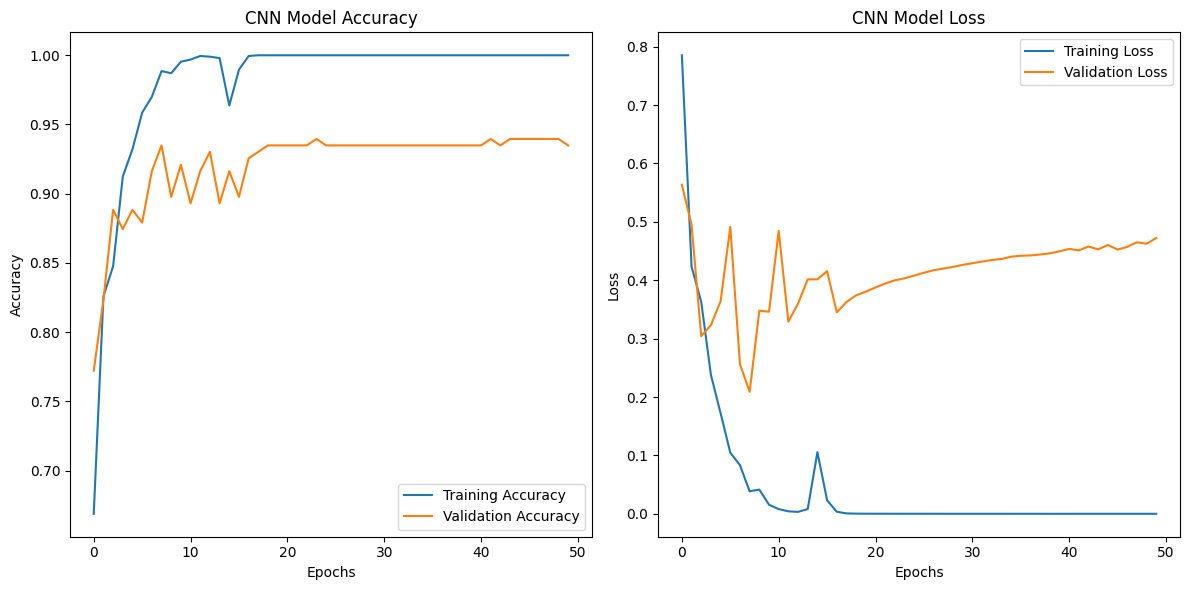

In [21]:
# plotting accuracy and loss over epochs 
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot accuracy and loss
plot_accuracy_and_loss(history)

creating the keras model as extract_features where input will be same as cnn_model and output will be second last layer which is basically dense layer which contains high level features.Then the model extract_features to each x_train data. This means that each sample in x_train is passed through the extract_features model, and the activations of the second-to-last layer (features) are computed for each sample.
Similarly, applies the extract_features model to the x_test data, computing the features for each sample in x_test.

In [22]:
# extracting features from cnn(feature extraction)
extract_features = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)
train_features = extract_features.predict(x_train)
test_features = extract_features.predict(x_test)

67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step


Training an SVM model with features extracted from a CNN.First initializing the SVM, then extracted features from the CNN as input, and providing corresponding labels for supervised learning

In [23]:
#training svm model
svm = SVC()
svm.fit(train_features, y_train)

SVC()

label for test data is predicted using SVM and test_features are the extracted features from the CNN model for the test dataset. Each row in test_features represents the features extracted from one test sample.

In [29]:
#accuracy of svm
svm_pred = svm.predict(test_features)
svm_accuracy = accuracy_score(y_test, svm_pred)*100
print("The obtained SVM model accuracy is:", svm_accuracy)

The obtained SVM model accuracy is: 92.5


Here 180 images in test set were predicted correctly(true positive) and class 0 and 30 images were falsely predicted(false positive) as class 1 but belong to class 0 and 0 images where falsey predicted as class 2 but belong to class 0 simlilary for rest all classes too.

Confusion Matrix is:
 [[180  30   0]
 [ 28 404   4]
 [  7   0 267]]


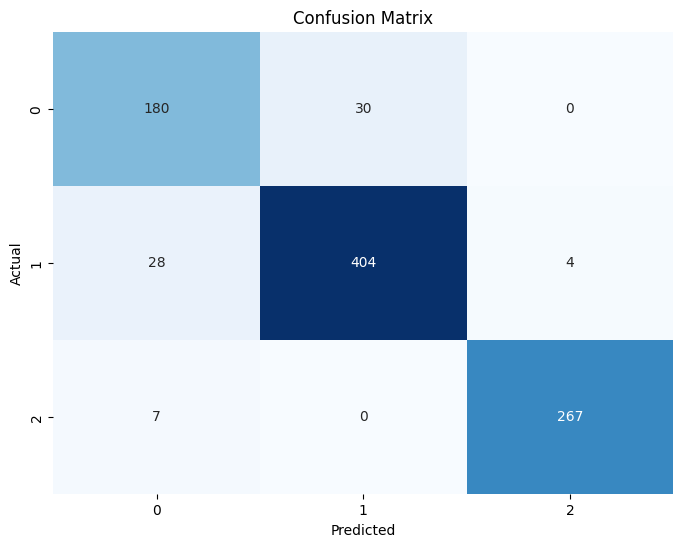

In [36]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Example of computing confusion matrix
cm = confusion_matrix(y_test, svm_pred)
print("Confusion Matrix is:\n",cm)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [37]:
# classification report
print("\nClassification Report:")
print(classification_report(y_test, svm_pred, target_names=['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']))


Classification Report:
                  precision    recall  f1-score   support

meningioma_tumor       0.84      0.86      0.85       210
    glioma_tumor       0.93      0.93      0.93       436
 pituitary_tumor       0.99      0.97      0.98       274

        accuracy                           0.93       920
       macro avg       0.92      0.92      0.92       920
    weighted avg       0.93      0.93      0.93       920



saving the cnn model for further use

In [38]:
from tensorflow.keras.models import load_model

# Define the path where you want to save the CNN model
cnn_model_new_save_path = 'cnn_model_final.h5'

# Save the CNN model
cnn_model.save(cnn_model_new_save_path)
print(f"Saved trained CNN model at {cnn_model_new_save_path}")

Saved trained CNN model at cnn_model_final.h5


In [39]:
import joblib

# Define the path where you want to save the SVM model
svm_model_new_save_path = 'svm_model_final.pkl'

# Save the SVM model
joblib.dump(svm, svm_model_new_save_path)
print(f"Saved trained SVM model at {svm_model_new_save_path}")

Saved trained SVM model at svm_model_final.pkl
